In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset

In [2]:
df = pd.read_csv("bank_transactions.csv")

In [3]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Preview dataset
print(df.head())
print(df.info())

  CustomerID TransactionDate  TransactionAmount  Age  Gender          City  \
0    CUST001      2025-01-15            1553.98   67  Female    Fort Worth   
1    CUST002      2025-01-16            3190.60   29  Female      San Jose   
2    CUST003      2025-01-17            4103.36   28    Male      San Jose   
3    CUST004      2025-01-18            3676.32   67  Female       Houston   
4    CUST005      2025-01-19            4203.17   28  Female  Jacksonville   

  Account Type  
0       Credit  
1     Checking  
2      Savings  
3       Credit  
4      Savings  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         500 non-null    object        
 1   TransactionDate    500 non-null    datetime64[ns]
 2   TransactionAmount  500 non-null    float64       
 3   Age                500 non-null    int64     

C:\Users\hp\AppData\Local\Temp\ipykernel_7472\3196757294.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [4]:
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

In [5]:
# Creating RFM Table

import datetime as dt
dictsnapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days, #Recency
    'CustomerID': 'count',                                       #Frequency
    'TransactionAmount': 'sum'                                   #Monetary
})

# Renaming columns
rfm.rename(columns={
    'TransactionDate': 'Recency',
    'CustomerID': 'Frequency',
    'TransactionAmount': 'Monetary'
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
CUST001         500          1   1553.98
CUST002         499          1   3190.60
CUST003         498          1   4103.36
CUST004         497          1   3676.32
CUST005         496          1   4203.17


In [6]:
# Creating RFM Scores

# Recovery score: lower days = better
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'),5, labels=[1,2,3,4,5])

# Monetary score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]) 
# Final RFM Score
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
CUST001,500,1,1553.98,1,1,2,4
CUST002,499,1,3190.60,1,1,3,5
CUST003,498,1,4103.36,1,1,4,6
CUST004,497,1,3676.32,1,1,4,6
CUST005,496,1,4203.17,1,1,5,7


In [7]:
# Defining Customer Segements

def segement_customer(score):
    if score >= 12:
        return "Champions"
    elif score >= 9:
        return "Loyal Customers"
    elif score >= 6:
        return "Potential Loyality"
    else:
        return "At Risk"
    
rfm['Segement'] = rfm['RFM_Score'].apply(segement_customer)

print(rfm['Segement'].value_counts())


Segement
Loyal Customers       160
Potential Loyality    145
Champions             118
At Risk                77
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_7472\604497540.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segement', order=rfm['Segement'].value_counts().index, palette="viridis")


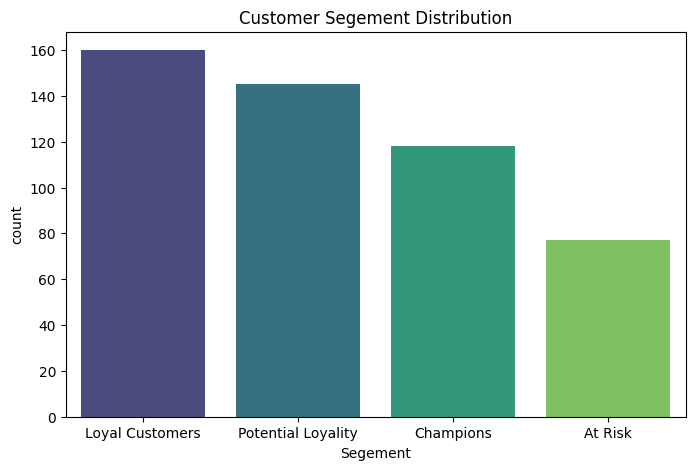

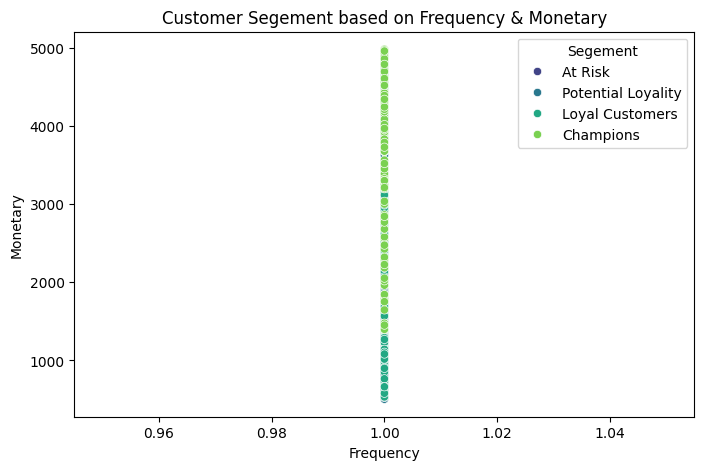

In [8]:
# Visualization

# Segement Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segement', order=rfm['Segement'].value_counts().index, palette="viridis")
plt.title("Customer Segement Distribution")
plt.show()

# Frequency vs Monetary
plt.figure(figsize=(8,5))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segement', palette="viridis")
plt.title("Customer Segement based on Frequency & Monetary")
plt.show()

In [9]:
rfm.to_csv("customer_segement.csv", index=True)